# Прогнозирование классифицированных данных

Временной ряд составлен из классифицированной динамики статистики СОТ по одному оператору. 

Интервал (**interval**) задает количество прошлых периодов, сравниваемых с текущим. Для каждого периода составляется числовой ряд из прошлых значений в диапазоне интервала. Каждый числовой ряд сравнивается с такими же рядами в прошлом - наиболее похожие из них фильтруются по сумме квадратов разностей (**entry_ssq**). Если совпадений слишком мало (**min_ssq_target**) для достоверности, показатель обнуляется. В дальнейшем для числовых рядов с нулевым количеством сопадений - прогноз ***Неопределенный***.

Для всех совпавших и неотфильтрованных числовых рядов выводятся исходные значения (из классифицированной статистики) - на их основе рассчитывается прогноз.
Для ряда из исходных показателей рассчитывается среднее значение и стандартное отклонение. 
*   Стандартное отклонение не должно превышать устанавливаемый параметр (**max_deviation**), иначе прогноз ***Неопределенный***
*   Среднее значение не должно чрезмерно отклоняться от целого (**max_dev_fr_intmean**), иначе прогноз ***Неопределенный***



# Загрузка данных

In [378]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import copy

In [379]:
# Статистика СОТ
df1_url = "https://raw.githubusercontent.com/ForestTiger-GH/COTRA/main/Stat_wheat/StatisticsClassified_0.5_all536_3binYs.txt"
df1 = pd.read_csv(df1_url,
               sep='\t', 
               error_bad_lines=False,
               decimal=',',
               encoding='gbk', 
               skiprows=1)
OI = df1.iloc[:, 1:2]
npOI = np.array(OI, dtype=int)
df1_name = OI.columns

In [380]:
# Котировки
df2_url = "https://raw.githubusercontent.com/ForestTiger-GH/COTRA/main/Stat_wheat/PRICE_Wheat_2010-2020.txt"
df2_name = "Wheat futures: 23.03.2010 - 30.06.2020"
df2 = pd.read_csv(df2_url,
               sep='\t', 
               error_bad_lines=False,
               decimal=',',
               encoding='gbk', 
               skiprows=0)
price = df2.iloc[:, 1:2]

In [381]:
# Доп обработка npOI
aa = []
for i in range(len(OI)):
    aa.append(npOI[i][0])
npOI = aa

Пример последовательности: [0, 0, 6, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 2, 2, 0, 0, 0, 6, 0, 0, 0, 0, 1, 0]



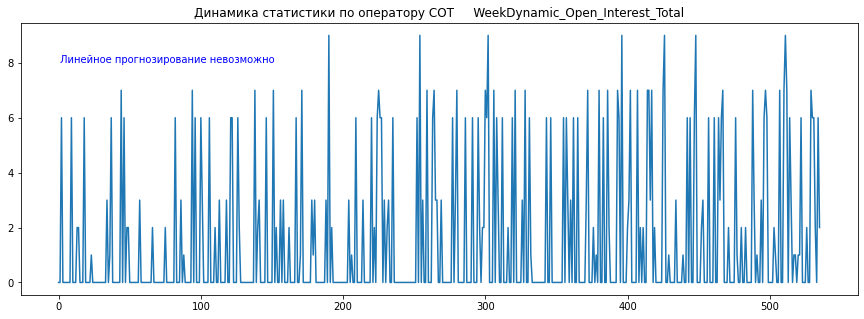

In [382]:
# Результат
print("Пример последовательности: "+str(npOI[0:25]), end='\n\n')
plt.figure(figsize=(15,5))
plt.title("Динамика статистики по оператору СОТ     "+str(df1_name[0]))
plt.text(1, 8, "Линейное прогнозирование невозможно", color = 'blue')
plt.plot(OI)

# Параметры


In [383]:
# ------------ ВВОДНЫЕ ------------ #

interval = 5                                                                    # Размерность окна
entry_ssq = 8                                                                   # Пороговая СУММКВРАЗНОСТЬ
min_ssq_target = 5                                                              # Минимальное количество СУММКВРАЗНОСТей
max_deviation = 1.                                                             # Стандартное отклонение, не более
max_dev_fr_intmean = 0.11                                                      # Отклонение от целого среднего, не более

# ------------ РАСЧЕТНЫЕ ------------ #

full_length = len(OI)
cut_length = full_length - interval
shift = 1

# Функции

In [384]:
def sum_squares_differences(first_array, second_array):
    if not len(first_array) == len(second_array):
        raise Exception("Input arrays are different sizes")
    array_len = len(first_array)
    total = []
    squares = []
    for i in range(array_len):
        squares.append((first_array[i] - second_array[i])**2)
    total = sum(squares)
    return total

# Создание цифрового ряда

In [385]:
# Отсечка верхних значений X и формирование ряда
setting_X = []
for q in range(full_length):
    aaa = []
    if q < interval:
        continue
    for i in range(interval):
        aaa.append(npOI[q-i-1])
    setting_X.append(aaa)

In [386]:
# Отсечка верхних значений Y
setting_Y = []
for w in range(full_length):
    if w < interval:
        continue
    setting_Y.append(npOI[w])

# Циклическая обработка рядов

In [387]:
# Сдвиг на строку, затем сравнение всех сумм квадратов разностей для всех комбинаций
# Одновременно собирается список Y-ков под все совпадения
# Затем считаются средние показатели и прогнозные значения

matches = []
inits = []
ggg = []
effe = []
for i in range(cut_length):
    bbb = []
    if i < shift:
        matches.append(0)
        bbb = []
        inits.append(np.array(bbb).tolist())
        continue
    else:
        fff = []
        for q in range(i):
            abc = sum_squares_differences(setting_X[i], setting_X[i-q])
            if abc <= entry_ssq:
                fff.append(setting_Y[i-q])
                if q == 0:
                    matches.append(1)
                else:
                    matches[i] += 1
            else:
                if q == 0:
                    matches.append(0)
                else:
                    matches[i] += 0
            if q == i-1:
                if matches[i] < min_ssq_target:
                    fff = []
                    matches[i] = 0
    inits.append(np.array(fff).tolist())
    
    # Среднее и среднеквадратичное отклонение
    mean = []
    for r in range(len(inits)):
        mean.append(np.mean(inits[r]))
    
    dev = []
    for s in range(len(inits)):
        dev.append(np.std(inits[s]))


    # Прогнозные значения

    predict_dev = []             # условие: 0 или 1
    for t in range(len(inits)):
        if dev[t] < max_deviation:
            predict_dev.append(1)
        else:
            predict_dev.append(0)

    
    predict_mean = []            # округленное абсолютное значение
    for v in range(len(mean)):
        predict_mean_check = []
        if mean[v] == 'nan':
            predict_mean.append('nan')
            continue
        else:
            predict_mean_check = mean[v] - round(mean[v], 0)
            if abs(predict_mean_check) <= max_dev_fr_intmean:
                predict_mean.append(mean[v])
            else:
                predict_mean.append('nan')
    
    
    predict = []
    for k in range(len(inits)):
        if predict_dev[k] == 1:
            # predict.append(round(predict_mean[k],0))
            if predict_mean[k] == 'nan':
                predict.append('nan')
            else:
                predict.append(round(predict_mean[k],0))
        else:
            predict.append('nan')

    # Разница прогнозных и реальных значений
    dif = []
    ef = []
    amount_predictions = 0
    for w in range(len(inits)):
        if predict[w] == 'nan':
            dif.append('nan')
            continue
        else:
            amount_predictions += 1
            dif.append(predict[w] - setting_Y[w])
            if (predict[w] - setting_Y[w]) == 0:
                ef.append(1)
            else:
                ef.append(0)
    if len(ef) == 0:
        effe.append(0)
    else:
        effe.append(sum(ef)/len(ef))

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


# Результаты

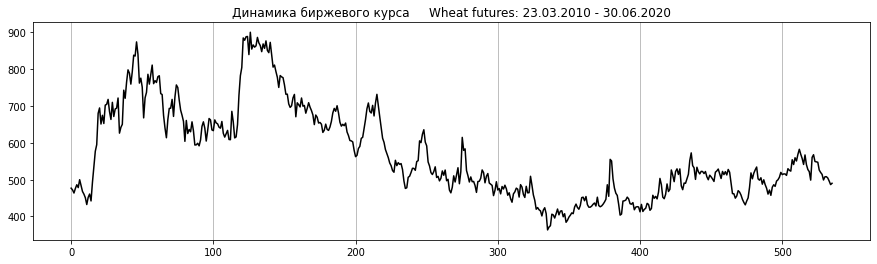

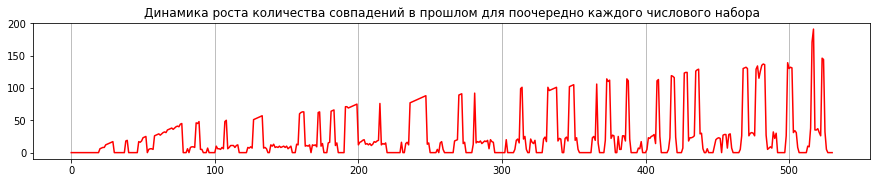

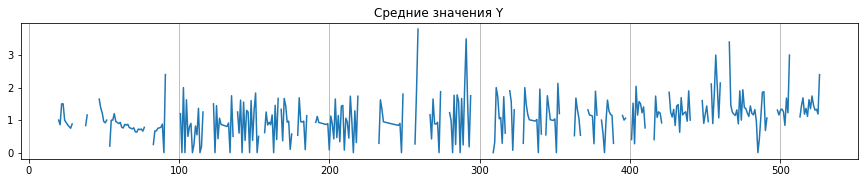

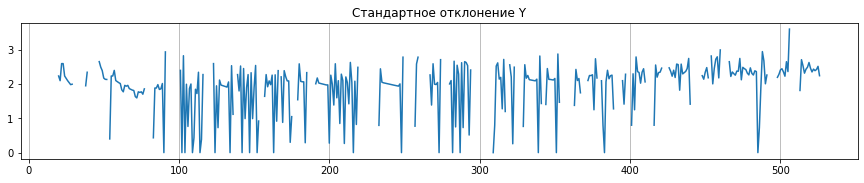


КОЛИЧЕСТВО ПРОГНОЗОВ за всё время:      26



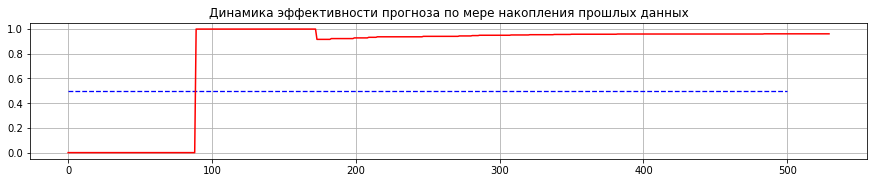

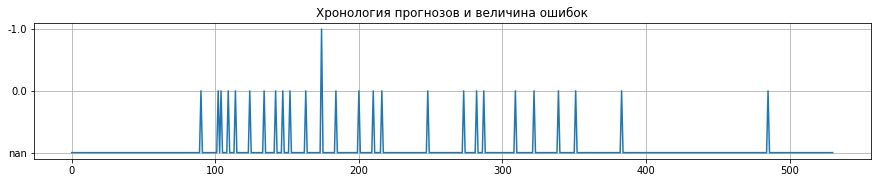

In [388]:
plt.figure(figsize=(15,4))
plt.grid(axis='x')
plt.title("Динамика биржевого курса     "+df2_name)
plt.plot(price, color = 'black')
plt.show()
print()
plt.figure(figsize=(15,2.5))
plt.grid(axis='x')
plt.title("Динамика роста количества совпадений в прошлом для поочередно каждого числового набора")
# plt.text(-22, 60, "Со временем для числовых рядов накапливаются десятки и иногда сотни совпадений в прошлом", color = 'blue')
plt.plot(matches, color = 'red')
plt.show()
print()
plt.figure(figsize=(15,2.5))
plt.grid(axis='x')
plt.title("Средние значения Y")
# plt.text(30, 5, "Большая часть значений колеблется у средних значений: 4 и 5", color = 'blue')
plt.plot(mean)
plt.show()
print()
# print(np.around(dev[0:25], 2), end='\n\n')
plt.figure(figsize=(15,2.5))
plt.grid(axis='x')
plt.title("Стандартное отклонение Y")
# plt.text(30, 2, "Достоверно низких отклонений мало", color = 'blue')
plt.plot(dev)
plt.show()
print()
print("КОЛИЧЕСТВО ПРОГНОЗОВ за всё время:      "+str(amount_predictions), end='\n\n')
plt.figure(figsize=(15,2.5))
plt.grid()
plt.hlines(0.5, 0, 500, color = 'blue', linewidth = 1.3, linestyle = '--')
plt.title("Динамика эффективности прогноза по мере накопления прошлых данных")
plt.plot(effe, color = 'red')
plt.show()
print()
plt.figure(figsize=(15,2.5))
plt.title("Хронология прогнозов и величина ошибок")
plt.grid()
plt.plot(dif)

# Вывод статистики прогнозов

In [389]:
columns = []
columns.append(df1_name[0])

In [390]:
data = predict
df_new = pd.DataFrame(data, columns=columns)
df_new.to_csv(index=False)

'WeekDynamic_Open_Interest_Total\nnan\nnan\nnan\nnan\nnan\nnan\nnan\nnan\nnan\nnan\nnan\nnan\nnan\nnan\nnan\nnan\nnan\nnan\nnan\nnan\nnan\nnan\nnan\nnan\nnan\nnan\nnan\nnan\nnan\nnan\nnan\nnan\nnan\nnan\nnan\nnan\nnan\nnan\nnan\nnan\nnan\nnan\nnan\nnan\nnan\nnan\nnan\nnan\nnan\nnan\nnan\nnan\nnan\nnan\nnan\nnan\nnan\nnan\nnan\nnan\nnan\nnan\nnan\nnan\nnan\nnan\nnan\nnan\nnan\nnan\nnan\nnan\nnan\nnan\nnan\nnan\nnan\nnan\nnan\nnan\nnan\nnan\nnan\nnan\nnan\nnan\nnan\nnan\nnan\nnan\n0.0\nnan\nnan\nnan\nnan\nnan\nnan\nnan\nnan\nnan\nnan\nnan\n0.0\nnan\n0.0\nnan\nnan\nnan\nnan\n0.0\nnan\nnan\nnan\nnan\n0.0\nnan\nnan\nnan\nnan\nnan\nnan\nnan\nnan\nnan\n0.0\nnan\nnan\nnan\nnan\nnan\nnan\nnan\nnan\nnan\n0.0\nnan\nnan\nnan\nnan\nnan\nnan\nnan\n0.0\nnan\nnan\nnan\nnan\n0.0\nnan\nnan\nnan\nnan\n0.0\nnan\nnan\nnan\nnan\nnan\nnan\nnan\nnan\nnan\nnan\n0.0\nnan\nnan\nnan\nnan\nnan\nnan\nnan\nnan\nnan\nnan\n0.0\nnan\nnan\nnan\nnan\nnan\nnan\nnan\nnan\nnan\n0.0\nnan\nnan\nnan\nnan\nnan\nnan\nnan\nnan\nn